In [1]:
# Importing libs
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# For embedding generation
from sentence_transformers import SentenceTransformer, util

# For nearest neighbor search
from sklearn.neighbors import NearestNeighbors

# For visualising
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set aesthetic style for plots
sns.set(style="whitegrid", palette="viridis", font_scale=1.2)

# Set device for SentenceTransformer (will use MPS if available on macOS, otherwise CPU)
import torch
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


### Loading the Preprocessed Data

Load the data if it is available or preprocess it if not

In [2]:
# Defining the path for the preprocessed data
preprocessed_file = os.path.join("../data", "preprocessed_wikitext103_subset.csv")

In [3]:
# Step 1: Load preprocessed data (or run preprocessing if not available)
if os.path.exists(preprocessed_file):
    print("Loading preprocessed data from local disk...")
    # df = pd.read_csv(preprocessed_file, on_bad_lines='skip', engine='python')
    # loading in chunks
    with open(preprocessed_file, 'r', encoding='utf-8', errors='ignore') as f:
        total_lines = sum(1 for line in f) - 1

    chunk_size = 10000  # adjust chunk size as needed
    total_chunks = total_lines // chunk_size

    # Read CSV in chunks and display progress
    chunks = []
    for chunk in tqdm(pd.read_csv(preprocessed_file, on_bad_lines='skip', engine='python', chunksize=chunk_size),
                      total=total_chunks,
                      desc="Loading CSV"):
        chunks.append(chunk)

    # Combine all chunks into one DataFrame
    df = pd.concat(chunks, ignore_index=True)
    # same amount of data as in contamination_detector
    df = df.sample(frac=0.45, random_state=42).copy()
else:
    print("Preprocessed data not found. Running preprocessing...")
    # Here I am just raising an error now but we will be converting preprocessing_data notebook to get the pipeline and use it here.
    raise FileNotFoundError("Preprocessed data not found. Please run the data preprocessing module first.")

Loading preprocessed data from local disk...


Loading CSV:   0%|          | 0/149 [00:00<?, ?it/s]

In [4]:
# Exploration that the data loading is correct
print("Loaded data shape:", df.shape)
print("Sample segments:")
print(df['segments'].head())

Loaded data shape: (671637, 3)
Sample segments:
188882     try to coax him with a ball or two just inside...
1210893                                           doubtless!
1121359    = = lyrics and composition = = the song makes ...
1478668    an indian-summer reverie what visionary tints ...
173784     the use of such substances in track and field ...
Name: segments, dtype: object


In [5]:
# Ensure the 'segments' column is string type
df['segments'] = df['segments'].astype(str)

### Embeddings

In this step we generate the embeddings if they are not already there OR just load them if they are saved locally.

In [6]:
# Embeddings file path
embeddings_file = os.path.join("../data", "segment_embeddings.npy")

In [7]:
# Step 2: Generate or load embeddings for each segment
if os.path.exists(embeddings_file):
    print("Loading precomputed embeddings from disk...")
    embeddings = np.load(embeddings_file)
else:
    print("Generating embeddings for segments...")
    # Initialize the embedding model (efficient and fast)
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

    def compute_embeddings(texts, batch_size=32):
        return embedding_model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_tensor=False)
        # I have written show_progress_bar here but if you generally have no proper installation of ipykernel or ipywidget, you can forget about seeing it :)

    segments = df['segments'].tolist()
    embeddings = np.array(compute_embeddings(segments, batch_size=32))
    # Save embeddings for future use
    os.makedirs(os.path.dirname(embeddings_file), exist_ok=True)
    np.save(embeddings_file, embeddings)
    print("Embeddings generated and saved.")

print("Embeddings shape:", embeddings.shape)

Generating embeddings for segments...


Batches:   0%|          | 0/20989 [00:00<?, ?it/s]

Embeddings generated and saved.
Embeddings shape: (671637, 384)


### Neighborhood Similarity analysis

Here we perform a nearest neighbor search on the embeddings. I am using scikit learn NearestNeighbours with cosine metric, and computing the closest neighbors for each segment.

We were using BERT (via AutoTokenizer and AutoModel) before but it had mainly two problems with the implementation:
1. it wasn't performed correctly
2. AND, it can be more slower and memory intensive if ran locally

For this we decided to change the implemenation to SentenceTransformer (“all‑MiniLM‑L6‑v2”)

In [8]:
# Note: Cosine similarity = 1 - cosine distance, so we convert distances to similarities.
n_neighbors = 6  # includes self + 5 nearest neighbors
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
nn_model.fit(embeddings)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [9]:
# Find nearest neighbors for each embedding
distances, indices = nn_model.kneighbors(embeddings)

In [10]:
# Convert distances to similarities (self-distance is 0 -> similarity 1)
similarities = 1 - distances

In [11]:
# For each segment, ignore self (first neighbor should be itself with similarity 1)
max_neighbor_sim = []
for sim in similarities:
    # Exclude the first element (self)
    max_sim = np.max(sim[1:])  # maximum similarity among neighbors
    max_neighbor_sim.append(max_sim)

df['max_neighbor_similarity'] = max_neighbor_sim

We also needed to define thresholds for MIA

**Thresholds:**
- **High Similarity (Duplicate Flag):** If any neighbor (excluding itself) has cosine similarity ≥ 0.95.
- **Outlier Flag:** If no neighbor has a cosine similarity ≥ 0.3 (i.e. the maximum similarity is very low).

In [12]:
# Define thresholds
high_sim_threshold = 0.95  # potential duplicates/memorized
low_sim_threshold = 0.3    # potential outliers

In [13]:
# Flag segments
df['duplicate_flag'] = df['max_neighbor_similarity'] >= high_sim_threshold
df['outlier_flag'] = df['max_neighbor_similarity'] < low_sim_threshold

In [14]:
# Combine into a final membership inference flag (either condition)
df['membership_inference_flag'] = df['duplicate_flag'] | df['outlier_flag']

In [15]:
# Summary of what has happened
print("Summary of flagged segments:")
print("Duplicates (similarity >= 0.95):", df['duplicate_flag'].sum())
print("Outliers (max similarity < 0.3):", df['outlier_flag'].sum())
print("Total flagged:", df['membership_inference_flag'].sum())

Summary of flagged segments:
Duplicates (similarity >= 0.95): 46301
Outliers (max similarity < 0.3): 0
Total flagged: 46301


#### Visualisations for better understanding

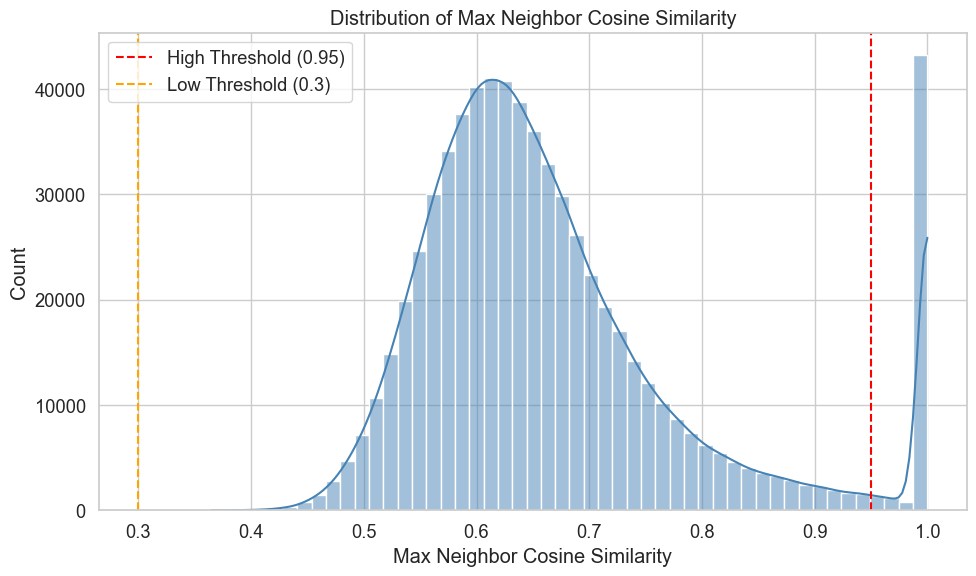

In [16]:
# Plot 1: Distribution of Max Neighbor Cosine Similarity
plt.figure(figsize=(10, 6))
sns.histplot(df['max_neighbor_similarity'], bins=50, kde=True, color="steelblue")
plt.axvline(x=high_sim_threshold, color='red', linestyle='--', label=f'High Threshold ({high_sim_threshold})')
plt.axvline(x=low_sim_threshold, color='orange', linestyle='--', label=f'Low Threshold ({low_sim_threshold})')
plt.xlabel("Max Neighbor Cosine Similarity")
plt.ylabel("Count")
plt.title("Distribution of Max Neighbor Cosine Similarity")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_20699/2049470668.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Flag Category', y='Count', data=flag_counts_df, palette="magma")


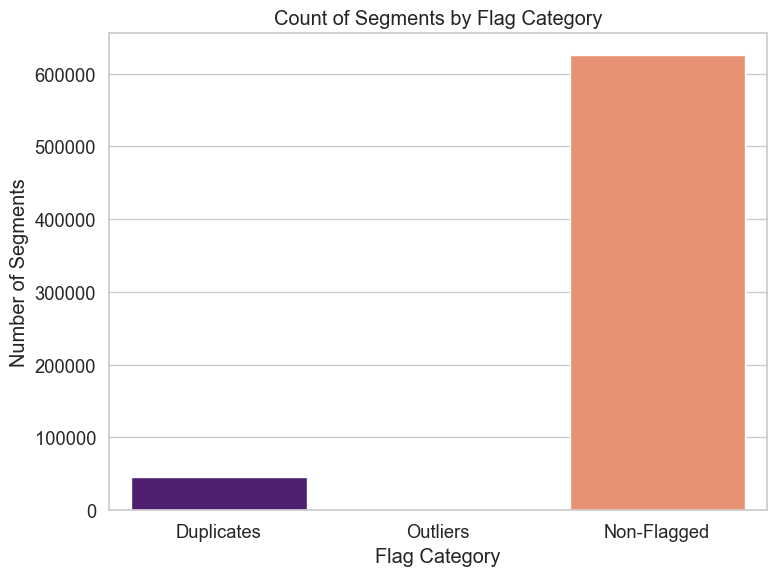

In [17]:
# Plot 2: Bar Plot of Flagged Categories
# Create a DataFrame with counts for each flag category
flag_counts = {
    "Duplicates": df['duplicate_flag'].sum(),
    "Outliers": df['outlier_flag'].sum(),
    "Non-Flagged": len(df) - df['membership_inference_flag'].sum()
}
flag_counts_df = pd.DataFrame(list(flag_counts.items()), columns=['Flag Category', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Flag Category', y='Count', data=flag_counts_df, palette="magma")
plt.title("Count of Segments by Flag Category")
plt.xlabel("Flag Category")
plt.ylabel("Number of Segments")
plt.tight_layout()
plt.show()

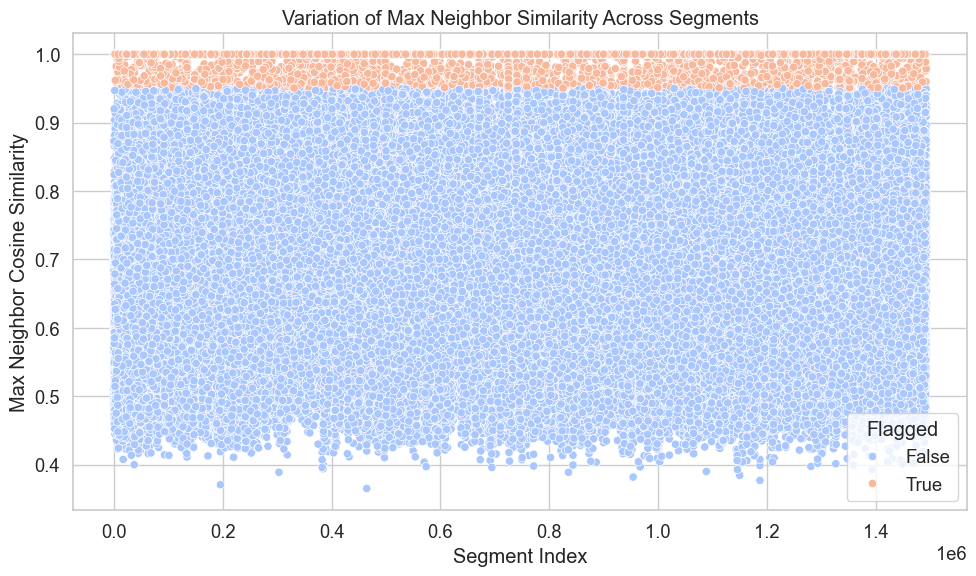

In [18]:
# Plot 3: Scatter Plot of Max Neighbor Similarity Across Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['max_neighbor_similarity'], hue=df['membership_inference_flag'],
                palette="coolwarm", legend="full")
plt.xlabel("Segment Index")
plt.ylabel("Max Neighbor Cosine Similarity")
plt.title("Variation of Max Neighbor Similarity Across Segments")
plt.legend(title="Flagged")
plt.tight_layout()
plt.show()

### Saving the results

In [19]:
output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "membership_inference_flags.csv")
df.to_csv(output_file, index=False)
print(f"Membership inference results saved to {output_file}")

Membership inference results saved to ../data/membership_inference_flags.csv
